In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.instance().ast_node_interactivity = "all"

In [2]:
from dataclasses import dataclass
from typing import Optional, Tuple

import lightning as pl
import numpy as np
import pandas as pd
import torch
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from torch import nn
from torch.utils.data import DataLoader, Dataset

torch.set_float32_matmul_precision("medium")  # 推荐选项

In [ ]:
# -*- coding: utf-8 -*-
"""
Lightning implementation:

Final model equation:
    y(X, t) = Σ_i k(t, t_i) β_i(X) + μ1(X) + μ2(t) + μ3(X, t)

Where:
- k(t, t_i) = exp(-(t - t_i)^2 / (2σ_i^2)) is the Gaussian kernel
- β(X): coefficients depending on X (with optional L2 regularization)
- μ1(X): baseline depending only on X
- μ2(t): baseline depending only on t
- μ3(X,t): baseline depending on interaction of X and t

Features:
- Implemented with `lightning` (new API)
- Gaussian kernel: centers and σ can be learnable
- β(X), μ1(X), μ2(t), μ3(X,t) are configurable MLPs
- Includes synthetic dataset, DataLoader, training/validation/testing pipeline
"""


# -------------------------
# Utility: build MLP
# -------------------------


def make_mlp(
    in_dim: int,
    out_dim: int,
    hidden_dims: Tuple[int, ...] = (128, 128),
    activation: str = "gelu",
    dropout: float = 0.0,
    use_batchnorm: bool = False,
) -> nn.Module:
    """Build a simple MLP with optional activation, batch norm and dropout."""
    acts = {
        "relu": nn.ReLU,
        "gelu": nn.GELU,
        "tanh": nn.Tanh,
        "leaky_relu": nn.LeakyReLU,
    }
    layers = []
    last = in_dim
    for h in hidden_dims:
        layers.append(nn.Linear(last, h))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(h))
        layers.append(acts.get(activation, nn.GELU)())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        last = h
    layers.append(nn.Linear(last, out_dim))
    return nn.Sequential(*layers)


def init_centers_and_sigmas(
    t_train: np.ndarray | None,
    n_kernels: int,
    method: str = "quantile",
    sigma_alpha: float = 0.5,
    t_range: Tuple[float, float] = (0.0, 1.0),
    **kwargs,
):
    """
    Initialize kernel centers and sigmas from training data distribution.
    - If t_train is None, fallback to evenly spaced centers over t_range and constant sigmas.
    - method: 'quantile' | 'hist' | 'kmeans'
    - sigma_alpha: scale factor for spacing to sigma
    """
    import numpy as np

    if t_train is None:
        centers = torch.linspace(t_range[0], t_range[1], n_kernels)
        sigmas = torch.full((n_kernels,), float(sigma_alpha))
        return centers, sigmas

    t = t = np.asarray(t_train).reshape(-1)

    if method == "quantile":
        qs = np.linspace(0.0, 1.0, num=n_kernels)
        centers = np.quantile(t, qs)
    elif method == "hist":
        bins = kwargs.get("bins", 64)
        hist, edges = np.histogram(t, bins=bins, density=True)
        pdf = hist / hist.sum()
        mids = 0.5 * (edges[:-1] + edges[1:])
        rng = np.random.default_rng(kwargs.get("seed", 0))
        idx = rng.choice(len(mids), size=n_kernels, replace=True, p=pdf)
        centers = mids[idx]
    elif method == "kmeans":
        iters = kwargs.get("iters", 50)
        rng = np.random.default_rng(kwargs.get("seed", 0))
        t_sorted = np.sort(t)
        centers = np.quantile(t_sorted, (np.arange(n_kernels) + 0.5) / n_kernels)
        for _ in range(iters):
            idx = np.argmin(np.abs(t_sorted[:, None] - centers[None, :]), axis=1)
            new_centers = []
            for k in range(n_kernels):
                pts = t_sorted[idx == k]
                new_centers.append(pts.mean() if len(pts) > 0 else centers[k])
            new_centers = np.array(new_centers)
            if np.allclose(new_centers, centers):
                break
            centers = new_centers
    else:
        raise ValueError("Unknown method")

    centers = torch.tensor(np.sort(centers), dtype=torch.float32)
    # derive sigma from neighbor spacing
    c = centers.detach().cpu().numpy()
    d = np.zeros_like(c)
    M = len(c)
    d[0] = c[1] - c[0] if M > 1 else 1.0
    d[-1] = c[-1] - c[-2] if M > 1 else 1.0
    for i in range(1, M - 1):
        d[i] = 0.5 * ((c[i] - c[i - 1]) + (c[i + 1] - c[i]))
    sigma = np.maximum(1e-3, sigma_alpha * d)
    sigmas = torch.tensor(sigma, dtype=torch.float32)
    return centers, sigmas


def init_weights_xavier_uniform(module: nn.Module):
    """Apply xavier_uniform initialization to all linear layers in a module."""
    for m in module.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)


# -------------------------
# Model: Gaussian kernel
# -------------------------
class GaussianKernel(nn.Module):
    """
    Gaussian kernel: k(t, t_i) = exp(-(t - t_i)^2 / (2σ_i^2))
    """

    def __init__(
        self,
        centers: torch.Tensor,
        sigmas: torch.Tensor,
        learnable_centers: bool = False,
        learnable_sigmas: bool = False,
        min_sigma: float = 1e-3,
    ):
        super().__init__()
        M = centers.numel()
        if centers.ndim != 1:
            raise ValueError("centers must be 1D [M]")
        if sigmas.ndim == 0:
            sigmas = sigmas.expand(M)
        elif sigmas.ndim != 1 or sigmas.numel() != M:
            raise ValueError("sigmas must be scalar or 1D with same length as centers")

        self.min_sigma = float(min_sigma)
        if learnable_centers:
            self.centers = nn.Parameter(centers.clone())
        else:
            self.register_buffer("centers", centers.clone())
        if learnable_sigmas:
            self.log_sigma = nn.Parameter(sigmas.clamp_min(self.min_sigma).log())
        else:
            self.register_buffer("log_sigma", sigmas.clamp_min(self.min_sigma).log())

    @property
    def sigmas(self) -> torch.Tensor:
        return self.log_sigma.exp().clamp_min(self.min_sigma)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """Compute kernel matrix for inputs t against all centers."""
        t = t.view(-1, 1)
        diff = t - self.centers.view(1, -1)
        denom = 2.0 * (self.sigmas.view(1, -1) ** 2)
        K = torch.exp(-(diff**2) / denom)
        return K


# -------------------------
# Main model: β(X), μ1(X), μ2(t), μ3(X,t)
# -------------------------


@dataclass
class ModelConfig:
    # property
    prop_name: str
    # input/output dimensions
    x_dim: int
    n_kernels: int
    # β(X)
    beta_hidden: Tuple[int, ...] = (128, 128)
    beta_activation: str = "gelu"
    beta_dropout: float = 0.0
    beta_batchnorm: bool = False
    # independent learning rate and weight decay for beta
    beta_weight_decay: float | None = None
    beta_lr: float | None = None  # defaults to lr if None
    # independent learning rate and weight decay for mu3
    mu3_weight_decay: float | None = None  # defaults to other_weight_decay if None
    mu3_lr: float | None = None  # defaults to lr if None
    # other/global lr & decay
    other_weight_decay: float = 1e-4
    lr: float = 1e-3
    # μ1(X)
    mu1_hidden: Tuple[int, ...] = (128,)
    mu1_activation: str = "gelu"
    mu1_dropout: float = 0.0
    mu1_batchnorm: bool = False
    # μ2(t)
    mu2_hidden: Tuple[int, ...] = (64,)
    mu2_activation: str = "gelu"
    mu2_dropout: float = 0.0
    mu2_batchnorm: bool = False
    # μ3(X,t)
    enable_mu3: bool = True
    mu3_hidden: Tuple[int, ...] = (128,)
    mu3_activation: str = "gelu"
    mu3_dropout: float = 0.0
    mu3_batchnorm: bool = False
    # kernel options
    learnable_centers: bool = False
    learnable_sigmas: bool = True
    init_sigma: float = 0.15
    # logging options
    log_points: int = 5  # number of points to log across kernels


class KernelRegression(LightningModule):
    """
    LightningModule implementing the kernel regression model:

    Final model equation:
        y(X, t) = Σ_i k(t, t_i) β_i(X) + μ1(X) + μ2(t) + μ3(X, t)

    Where:
    - k(t, t_i) = exp(-(t - t_i)^2 / (2σ_i^2)) is the Gaussian kernel
    - β(X): coefficients depending on X (with optional L2 regularization)
    - μ1(X): baseline depending only on X
    - μ2(t): baseline depending only on t
    - μ3(X,t): baseline depending on interaction of X and t

    Features:
    - Gaussian kernel: centers and σ can be learnable
    - β(X), μ1(X), μ2(t), μ3(X,t) are configurable MLPs
    - Training/validation/testing pipeline with logging of kernel parameters
    - Parameter groups for optimizer with configurable learning rates and weight decays
    """

    def __init__(
        self, cfg: ModelConfig, kernel_centers: torch.Tensor, kernel_sigmas: torch.Tensor, init_weights: bool = True
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["kernel_centers", "kernel_sigmas"])
        self.cfg = cfg

        M = cfg.n_kernels
        # validate kernel hyperparameters shape
        if kernel_centers.ndim != 1 or kernel_centers.numel() != M:
            raise ValueError("kernel_centers must be 1D tensor of length n_kernels")
        if kernel_sigmas.ndim != 1 or kernel_sigmas.numel() != M:
            raise ValueError("kernel_sigmas must be 1D tensor of length n_kernels")

        # Gaussian kernel module
        self.kernel = GaussianKernel(
            centers=kernel_centers.float(),
            sigmas=kernel_sigmas.float(),
            learnable_centers=cfg.learnable_centers,
            learnable_sigmas=cfg.learnable_sigmas,
        )

        # β(X) branch outputs per-kernel weights
        self.beta_net = make_mlp(
            cfg.x_dim, M, cfg.beta_hidden, cfg.beta_activation, cfg.beta_dropout, cfg.beta_batchnorm
        )

        # μ1(X) branch
        self.mu1_net = make_mlp(cfg.x_dim, 1, cfg.mu1_hidden, cfg.mu1_activation, cfg.mu1_dropout, cfg.mu1_batchnorm)

        # μ2(t) branch
        self.mu2_net = make_mlp(1, 1, cfg.mu2_hidden, cfg.mu2_activation, cfg.mu2_dropout, cfg.mu2_batchnorm)

        # μ3(X,t) optional interaction branch
        if cfg.enable_mu3:
            self.mu3_net = make_mlp(
                cfg.x_dim + 1, 1, cfg.mu3_hidden, cfg.mu3_activation, cfg.mu3_dropout, cfg.mu3_batchnorm
            )
        else:
            self.mu3_net = None

        # Apply xavier_uniform initialization if requested
        if init_weights:
            init_weights_xavier_uniform(self.beta_net)
            init_weights_xavier_uniform(self.mu1_net)
            init_weights_xavier_uniform(self.mu2_net)
            if self.mu3_net is not None:
                init_weights_xavier_uniform(self.mu3_net)

        # metrics
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass computing y(X,t).

        Args:
            x: [batch_size, x_dim] input features
            t: [batch_size] or [batch_size, 1] time values

        Returns:
            y: [batch_size, 1] predicted output
        """
        K = self.kernel(t)
        beta = self.beta_net(x)
        mu1 = self.mu1_net(x)
        mu2 = self.mu2_net(t.view(-1, 1))
        kbeta = (K * beta).sum(dim=1, keepdim=True)
        if self.mu3_net is not None:
            xt = torch.cat([x, t.view(-1, 1)], dim=1)
            mu3 = self.mu3_net(xt)
        else:
            mu3 = 0.0
        y = kbeta + mu1 + mu2 + mu3
        return y

    def training_step(self, batch, batch_idx):
        """
        Training step.

        Args:
            batch: tuple of (x, t, y)
            batch_idx: index

        Returns:
            loss
        """
        x, t, y = batch
        y_hat = self(x, t)
        loss = self.mse(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        # Log selected kernel parameters (centers and sigmas) to avoid slowdown.
        # We log at indices {0, s, 2s, ..., N} where N=M-1 and s≈N/(log_points-1).
        M = int(self.kernel.centers.numel())
        N = M - 1
        P = max(2, int(self.cfg.log_points))  # ensure at least {0, N}
        step = max(1, round(N / (P - 1)))
        idxs = sorted({min(i * step, N) for i in range(P)})

        if self.cfg.learnable_centers:
            centers_np = self.kernel.centers.detach().cpu().numpy()
            for i in idxs:
                self.log(f"center/{i}", float(centers_np[i]), prog_bar=False, on_step=False, on_epoch=True)
        if self.cfg.learnable_sigmas:
            sig_np = self.kernel.sigmas.detach().cpu().numpy()
            for i in idxs:
                self.log(f"sigma/{i}", float(sig_np[i]), prog_bar=False, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step.

        Args:
            batch: tuple of (x, t, y)
            batch_idx: index
        """
        x, t, y = batch
        y_hat = self(x, t)
        mse = self.mse(y_hat, y)
        mae = self.mae(y_hat, y)
        self.log_dict({"val_mse": mse, "val_mae": mae}, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """
        Test step.

        Args:
            batch: tuple of (x, t, y)
            batch_idx: index
        """
        x, t, y = batch
        y_hat = self(x, t)
        mse = self.mse(y_hat, y)
        mae = self.mae(y_hat, y)
        self.log_dict({"test_mse": mse, "test_mae": mae}, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Prediction step for Lightning prediction loop.

        Args:
            batch: tuple of (x, t, y)
            batch_idx: index
            dataloader_idx: index

        Returns:
            tuple of (t, y, y_hat)
        """
        x, t, y = batch
        y_hat = self(x, t)
        return t, y, y_hat

    def configure_optimizers(self):
        """
        AdamW with parameter groups:
        - β(X) branch: beta_weight_decay and beta_lr (defaults to lr if None)
        - other branches (μ1/μ2/kernel): other_weight_decay and lr
        - optional μ3 branch: mu3_weight_decay/mu3_lr (inherit if None)
        Bias and normalization parameters are excluded from decay.

        Returns:
            optimizer
        """

        def is_no_decay(name: str, p: torch.Tensor) -> bool:
            return p.ndim == 1 or ("bias" in name.lower()) or ("bn" in name.lower()) or ("norm" in name.lower())

        beta_decay, beta_no_decay = [], []
        for n, p in self.beta_net.named_parameters():
            (beta_no_decay if is_no_decay(n, p) else beta_decay).append(p)

        other_modules = [("mu1", self.mu1_net), ("mu2", self.mu2_net), ("kernel", self.kernel)]
        other_decay, other_no_decay = [], []
        for mname, mod in other_modules:
            for n, p in mod.named_parameters():
                (other_no_decay if is_no_decay(n, p) else other_decay).append(p)

        param_groups = []
        beta_lr = self.cfg.beta_lr if self.cfg.beta_lr is not None else self.cfg.lr
        mu3_lr = self.cfg.mu3_lr if self.cfg.mu3_lr is not None else self.cfg.lr
        mu3_wd = self.cfg.mu3_weight_decay if self.cfg.mu3_weight_decay is not None else self.cfg.other_weight_decay

        if beta_decay:
            param_groups.append({"params": beta_decay, "weight_decay": self.cfg.beta_weight_decay, "lr": beta_lr})
        if beta_no_decay:
            param_groups.append({"params": beta_no_decay, "weight_decay": 0.0, "lr": beta_lr})
        if other_decay:
            param_groups.append({"params": other_decay, "weight_decay": self.cfg.other_weight_decay, "lr": self.cfg.lr})
        if other_no_decay:
            param_groups.append({"params": other_no_decay, "weight_decay": 0.0, "lr": self.cfg.lr})

        # μ3 branch (optional)
        if self.mu3_net is not None:
            mu3_decay, mu3_no_decay = [], []
            for n, p in self.mu3_net.named_parameters():
                (mu3_no_decay if is_no_decay(n, p) else mu3_decay).append(p)
            if mu3_decay:
                param_groups.append({"params": mu3_decay, "weight_decay": mu3_wd, "lr": mu3_lr})
            if mu3_no_decay:
                param_groups.append({"params": mu3_no_decay, "weight_decay": 0.0, "lr": mu3_lr})

        optimizer = torch.optim.AdamW(param_groups)
        return optimizer

'\nLightning implementation:\n\nFinal model equation:\n    y(X, t) = Σ_i k(t, t_i) β_i(X) + μ1(X) + μ2(t) + μ3(X, t)\n\nWhere:\n- k(t, t_i) = exp(-(t - t_i)^2 / (2σ_i^2)) is the Gaussian kernel\n- β(X): coefficients depending on X (with optional L2 regularization)\n- μ1(X): baseline depending only on X\n- μ2(t): baseline depending only on t\n- μ3(X,t): baseline depending on interaction of X and t\n\nFeatures:\n- Implemented with `lightning` (new API)\n- Gaussian kernel: centers and σ can be learnable\n- β(X), μ1(X), μ2(t), μ3(X,t) are configurable MLPs\n- Includes synthetic dataset, DataLoader, training/validation/testing pipeline\n'

In [4]:
from typing import Tuple

import torch


class DOSDataset(Dataset):
    """
    将 desc(DataFrame), dos_energy(Series of list), dos(Series of list) 展开为 (D_j, t^j_i, v^j_i) 样本
    """

    def __init__(self, desc: pd.DataFrame, dos_energy: pd.Series, dos: pd.Series):
        super().__init__()
        self.samples = []
        # 遍历所有样本
        for idx in desc.index.intersection(dos.index).intersection(dos_energy.index):
            D_j = torch.tensor(desc.loc[idx].values, dtype=torch.float32)
            t_list = dos_energy.loc[idx]
            v_list = dos.loc[idx]
            # 保证长度一致
            if len(t_list) != len(v_list):
                continue
            for t_i, v_i in zip(t_list, v_list):
                t_tensor = torch.tensor([t_i], dtype=torch.float32)  # (1,)
                v_tensor = torch.tensor([v_i], dtype=torch.float32)  # (1,)
                self.samples.append((D_j, t_tensor, v_tensor))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.samples[idx]

In [5]:
class DOSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        desc: pd.DataFrame,
        dos_energy: pd.Series,
        dos: pd.Series,
        serial: Optional[pd.Series] = None,  # index->"train"/"val"/"test"
        batch_size: int = 32,
        random_seed: int = 42,
    ):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        self.serial = serial
        self.batch_size = batch_size
        self.random_seed = random_seed

    def setup(self, stage=None):
        if self.serial is not None:
            train_idx = self.serial[self.serial == "train"].index
            val_idx = self.serial[self.serial == "val"].index
            test_idx = self.serial[self.serial == "test"].index
        else:
            # 自动划分
            all_idx = np.array(list(self.desc.index.intersection(self.dos.index).intersection(self.dos_energy.index)))
            rng = np.random.RandomState(self.random_seed)
            perm = rng.permutation(len(all_idx))
            n = len(all_idx)
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)
            # n_test = n - n_train - n_val  # 未被使用，可删除
            train_idx = all_idx[perm[:n_train]]
            val_idx = all_idx[perm[n_train : n_train + n_val]]
            test_idx = all_idx[perm[n_train + n_val :]]
        self.train_dataset = DOSDataset(
            self.desc.loc[train_idx], self.dos_energy.loc[train_idx], self.dos.loc[train_idx]
        )
        self.val_dataset = DOSDataset(self.desc.loc[val_idx], self.dos_energy.loc[val_idx], self.dos.loc[val_idx])
        self.test_dataset = DOSDataset(self.desc.loc[test_idx], self.dos_energy.loc[test_idx], self.dos.loc[test_idx])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [6]:
import random

import matplotlib.pyplot as plt
import torch


def plot_prediction_pairs(
    samples,
    *,
    n=9,
    seed=42,
    prop_name="",
    title_prefix="Sample",
    show_true=True,
    show_pred=True,
    serial_name="",
):
    """
    输入 samples: List of (t, v_true) 或 (t, v_true, v_pred)
    自动判断有无 pred，进行单曲线或对比绘图
    只取每条曲线中间90%的数据进行绘制
    show_true: 是否绘制真实曲线
    show_pred: 是否绘制预测曲线
    xlabel: x轴标签，默认为""
    额外输出本次抽中的indices
    """
    random.seed(seed)  # 固定随机种子以确保可重复性

    indices = random.sample(range(len(samples)), n)
    print("plot_prediction_pairs indices:", indices)  # 输出抽中的indices
    n_cols = int(np.sqrt(n))
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        entry = samples[idx]
        if len(entry) == 2:
            t, v_true = entry
            v_pred = None
        elif len(entry) == 3:
            t, v_true, v_pred = entry
        else:
            raise ValueError("Each sample must be (t, v_true) or (t, v_true, v_pred)")

        t = t.squeeze(-1).cpu().numpy()
        v_true = v_true.squeeze(-1).cpu().numpy()
        n_points = len(t)
        start = int(n_points * 0.05)
        end = int(n_points * 0.95)
        t_mid = t[start:end]
        v_true_mid = v_true[start:end]

        ax = axes[i]
        if show_true:
            ax.plot(t_mid, v_true_mid, label="True", linewidth=1.5)
        if show_pred and v_pred is not None:
            v_pred = v_pred.squeeze(-1).cpu().numpy()
            v_pred_mid = v_pred[start:end]
            ax.plot(t_mid, v_pred_mid, label="Pred", linewidth=1.5)
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel(serial_name)
        ax.set_ylabel(prop_name)
        ax.legend()

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
import joblib
import pandas as pd
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250615.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")

/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.0 when using v

In [8]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

prop_name = _[3]

prop_value = qc_ac_te_mp_dos_data[prop_name].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop_name} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop_name} (T/K)"].loc[prop_value.index]
    if prop_name != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)
serial_name = "Temperature (K)" if prop_name != "DOS density" else r"$E - E_{ferim}$ (eV)"
desc = desc_trans.loc[prop_value.index]
split = qc_ac_te_mp_dos_data["split"].loc[prop_value.index]

In [9]:
BATCH_SIZE = 2048

dm = DOSDataModule(
    desc=desc,
    dos_energy=prop_T,
    dos=prop_value_norm,
    serial=split,
    batch_size=BATCH_SIZE,
    random_seed=42,
)
dm.setup()

In [ ]:
seed_everything(2025)

# -------------------------
# Configuration and training setup
# -------------------------

# Number of Gaussian kernels
# Note: this is a hyperparameter that can be tuned based on the dataset.
# More kernels can capture more complex patterns, but may also lead to overfitting.
# If you want to use a different number of kernels, change this value.
# For example, you can set N_KERNEL = 50 or N_KERNEL = 20 to see how it affects performance.
# The default value is 30, which is a good starting point for many datasets.
N_KERNEL = 10

# Learning rate and decay for the main model branches (μ1(X), μ2(t))
# Note: these are the global learning rate and decay for the main branches.
# If you want to use a different lr/decay for β(X) or μ3(X,t), set them explicitly in the config.
# LR_RATE = 5e-4
LR_RATE = 1e-3
OTHER_DECAY = 5e-5

# Learning rate and decay for β(X) branch
# Note: β(X) has a different learning rate and decay from the rest of the model.
# This is to ensure it can adapt independently, especially if it has a different scale.
# If you want to use the same lr/decay for β(X), set `beta_lr=None` and `beta_weight_decay=other_weight_decay`.
# BETA_LR_RATE = 5e-4
BETA_LR_RATE = 3e-4
# BETA_DECAY = 1e-4  # specific to β(X)
BETA_DECAY = 0  # specific to β(X)

# Learning rate and decay for μ3(X,t) branch
# If you want to use the same lr/decay for μ3(X,t) as the rest of the model, set `mu3_lr=None` and `mu3_weight_decay=other_weight_decay`.
# If you want a different lr/decay for μ3(X,t), set them explicitly.
MU3_LR_RATE = None  # inherit from `lr` if None
MU3_DECAY = None  # inherit from `other_weight_decay` if None

x_dim = desc.shape[1]
t_range = (prop_T.iloc[0].min(), prop_T.iloc[0].max())

cfg = ModelConfig(
    prop_name=prop_name,
    x_dim=x_dim,
    # kernel options
    n_kernels=N_KERNEL,
    learnable_centers=True,
    learnable_sigmas=True,
    # β(X) branch
    beta_hidden=(128, 64),
    beta_activation="gelu",
    beta_dropout=0.0,
    beta_batchnorm=False,
    beta_weight_decay=BETA_DECAY,  # regularization (decoupled L2 via AdamW) specific to β(X)
    beta_lr=BETA_LR_RATE,  # DIFFERENT lr for β(X); set None to inherit `lr`
    # μ1(X) branch
    mu1_hidden=(128, 64),
    mu1_activation="gelu",
    mu1_dropout=0.0,
    mu1_batchnorm=False,
    # μ2(t) branch
    mu2_hidden=(16, 8),
    mu2_activation="gelu",
    mu2_dropout=0.0,
    mu2_batchnorm=False,
    # μ3(X,t) branch
    enable_mu3=False,  # set to False to disable μ3(X,t) branch
    mu3_hidden=(128, 64),
    mu3_activation="gelu",
    mu3_dropout=0.0,
    mu3_batchnorm=False,
    mu3_lr=MU3_LR_RATE,  # inherit `lr` (change if you want a custom μ3 lr)
    mu3_weight_decay=MU3_DECAY,  # inherit `other_weight_decay` (or set a custom value)
    # other/global lr & decay
    other_weight_decay=OTHER_DECAY,  # default for others
    lr=LR_RATE,  # global lr for others
)


Seed set to 2025


2025

centers: tensor([   0.0000,  202.6667,  405.3333,  608.0000,  810.6667, 1013.3333,
        1216.0000, 1418.6666, 1621.3334, 1824.0000])
sigmas : tensor([91.2000, 91.2000, 91.2000, 91.2000, 91.2000, 91.2000, 91.2000, 91.2000,
        91.2000, 91.2000])


<Figure size 800x400 with 0 Axes>

(array([3.51821803e-04, 6.88264784e-04, 7.85054461e-04, 8.43990982e-04,
        9.67521679e-04, 1.16547712e-03, 1.21456745e-03, 1.22642977e-03,
        1.23801077e-03, 1.24741936e-03, 1.25704675e-03, 1.28042756e-03,
        1.29286815e-03, 1.29003932e-03, 1.27430104e-03, 1.20137667e-03,
        1.11271401e-03, 1.38385951e-03, 1.54024213e-03, 1.52670751e-03,
        1.52589481e-03, 1.49707515e-03, 1.42444773e-03, 1.40448964e-03,
        1.38962657e-03, 1.37174713e-03, 1.35096071e-03, 1.31723358e-03,
        1.29300881e-03, 1.27411349e-03, 1.23077460e-03, 1.19567212e-03,
        1.15467756e-03, 1.11346420e-03, 1.08920817e-03, 1.06574921e-03,
        1.02445770e-03, 9.79368373e-04, 9.37561109e-04, 8.99035910e-04,
        8.61620363e-04, 8.21172811e-04, 7.40215193e-04, 6.72088889e-04,
        5.74048901e-04, 5.05438101e-04, 4.51627855e-04, 3.84111077e-04,
        3.09498785e-04, 2.82726508e-04, 2.56001116e-04, 2.32526533e-04,
        2.08082959e-04, 1.68369965e-04, 1.42175956e-04, 1.164977

Text(0.5, 0, 't')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Centers and sigmas initialized from t distribution')

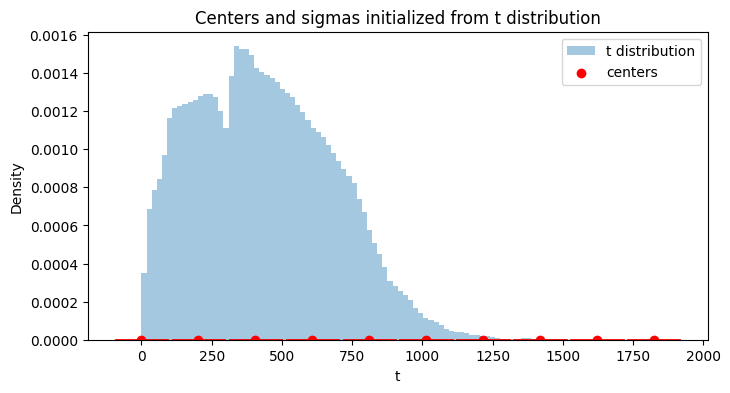

In [11]:
# initialize centers/sigmas from training t distribution
t_train = np.concatenate(prop_T.values)
t_range = (t_train.min(), t_train.max())  # ensure t_range is based on training data


centers, sigmas = init_centers_and_sigmas(
    # t_train=t_train,
    t_train=None,
    n_kernels=N_KERNEL,
    method="quantile",  # or 'hist' / 'kmeans'
    sigma_alpha=(t_train.max() - t_train.min()) / N_KERNEL / 2.0,  # spacing to sigma
    t_range=t_range,
)

print("centers:", centers)
print("sigmas :", sigmas)

# 绘制分布和 centers/sigmas
plt.figure(figsize=(8, 4))
plt.hist(t_train, bins=100, density=True, alpha=0.4, label="t distribution")

centers_np = centers.numpy()
sigmas_np = sigmas.numpy()

plt.scatter(centers_np, np.zeros_like(centers_np), color="red", label="centers")
for c, s in zip(centers_np, sigmas_np):
    plt.plot([c - s, c + s], [0, 0], color="red", lw=2)

plt.xlabel("t")
plt.ylabel("Density")
plt.title("Centers and sigmas initialized from t distribution")
plt.legend()
plt.show()

In [12]:
EPOCHS = 100

# Experiment 1: Use Fourier features
print("\n--- Experiment 1: Fourier feature encoding ---")

# model
model = KernelRegression(cfg, kernel_centers=centers, kernel_sigmas=sigmas)


callbacks = [
    EarlyStopping(monitor="val_mse", mode="min", patience=30),
    ModelCheckpoint(monitor="val_mse", mode="min", save_top_k=1, filename="best-{epoch:02d}-{val_mse:.4f}"),
    LearningRateMonitor(logging_interval="epoch"),
]
logger = [
    CSVLogger("logs/kernel_regression", name="csv"),
    TensorBoardLogger("logs/kernel_regression", name="tensorboard"),
]


trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    devices=[2],
    deterministic=True,
    log_every_n_steps=10,
    callbacks=callbacks,
    logger=logger,
)

# 4. Start training
trainer.fit(model, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Experiment 1: Fourier feature encoding ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | kernel   | GaussianKernel | 20     | train
1 | beta_net | Sequential     | 46.2 K | train
2 | mu1_net  | Sequential     | 45.6 K | train
3 | mu2_net  | Sequential     | 177    | train
4 | mae      | L1Loss         | 0      | train
5 | mse      | MSELoss        | 0      | train
----------------------------------------------------
91.9 K    Trainable params
0         Non-trainable params
91.9 K    Total params
0.368     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 38: 100%|██████████| 1201/1201 [00:29<00:00, 41.07it/s, v_num=3, val_mse=2.520, val_mae=1.270, train_loss=0.567]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 259/259 [00:01<00:00, 240.24it/s]
plot_prediction_pairs indices: [1309, 228, 51, 1518, 563, 501, 457, 285, 1508]


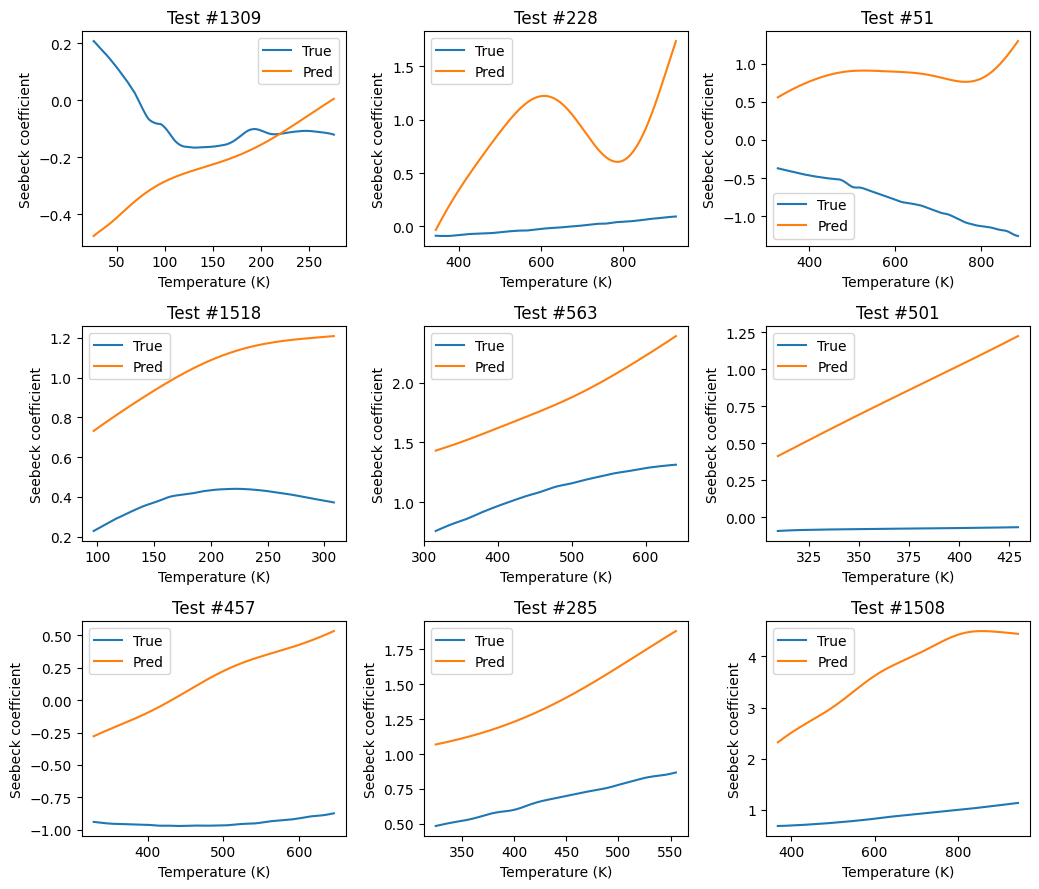

In [13]:
# 5. Predict
predictions = trainer.predict(model, dataloaders=dm.test_dataloader())

# 6. Visualize prediction results
# Concatenate results from all batches
all_t = []
all_v = []
all_y_hat = []

if predictions is not None:
    for batch in predictions:
        t, v, y_hat = batch
        all_t.append(t)
        all_v.append(v)
        all_y_hat.append(y_hat)
    all_t = torch.cat(all_t, dim=0)
    all_v = torch.cat(all_v, dim=0)
    all_y_hat = torch.cat(all_y_hat, dim=0)

    # Assume each D corresponds to a sequence length of 300
    seq_len = 300
    num_samples = all_t.shape[0] // seq_len

    samples = []
    for i in range(num_samples):
        t_seq = all_t[i * seq_len : (i + 1) * seq_len]
        v_seq = all_v[i * seq_len : (i + 1) * seq_len]
        y_hat_seq = all_y_hat[i * seq_len : (i + 1) * seq_len]
        samples.append((t_seq, v_seq, y_hat_seq))
    plot_prediction_pairs(
        samples, n=9, title_prefix="Test", prop_name=prop_name, serial_name=serial_name, show_pred=True
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 1201/1201 [00:04<00:00, 242.71it/s]
plot_prediction_pairs indices: [1824, 409, 4506, 4012, 3657, 2286, 1679, 1424, 6912]


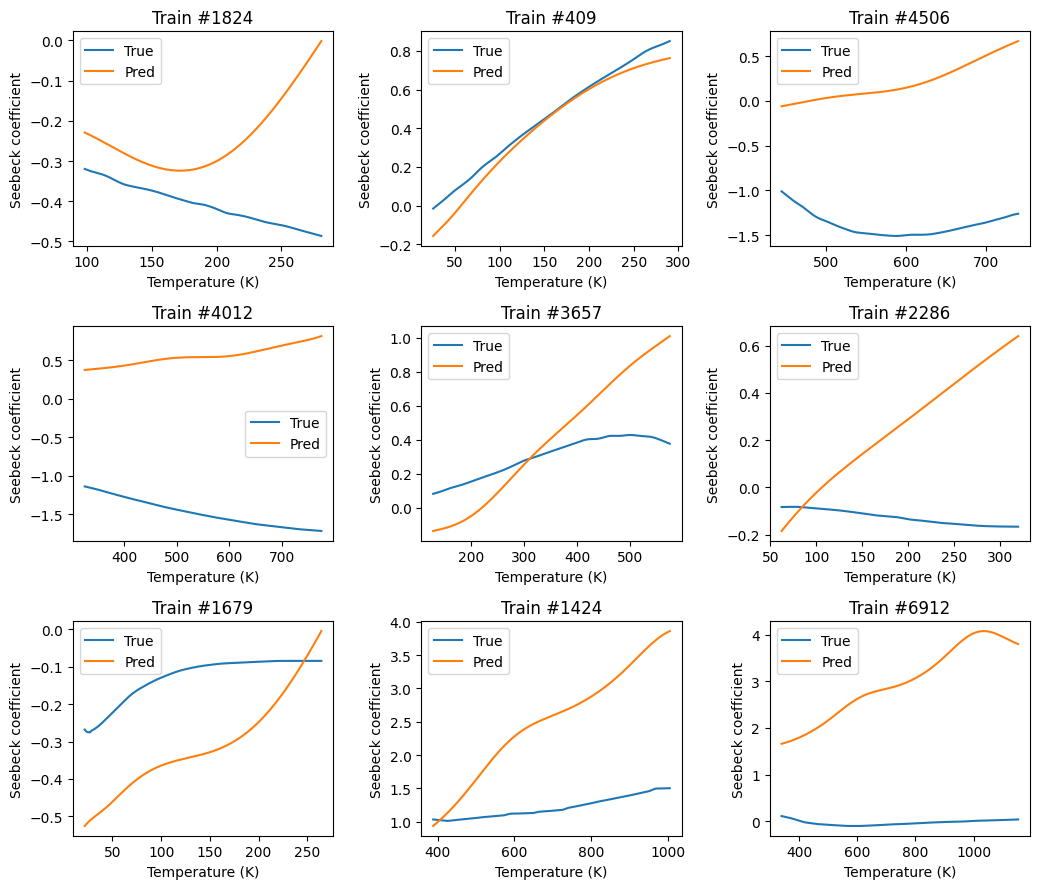

In [14]:
# 5. Predict
predictions = trainer.predict(model, dataloaders=dm.train_dataloader())

# 6. Visualize prediction results
# Concatenate results from all batches
all_t = []
all_v = []
all_y_hat = []

if predictions is not None:
    for batch in predictions:
        t, v, y_hat = batch
        all_t.append(t)
        all_v.append(v)
        all_y_hat.append(y_hat)
    all_t = torch.cat(all_t, dim=0)
    all_v = torch.cat(all_v, dim=0)
    all_y_hat = torch.cat(all_y_hat, dim=0)

    # Assume each D corresponds to a sequence length of 300
    seq_len = 300
    num_samples = all_t.shape[0] // seq_len

    samples = []
    for i in range(num_samples):
        t_seq = all_t[i * seq_len : (i + 1) * seq_len]
        v_seq = all_v[i * seq_len : (i + 1) * seq_len]
        y_hat_seq = all_y_hat[i * seq_len : (i + 1) * seq_len]
        samples.append((t_seq, v_seq, y_hat_seq))
    plot_prediction_pairs(
        samples, n=9, title_prefix="Train", prop_name=prop_name, serial_name=serial_name, show_pred=True
    )